In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

Reading the Pickle

In [25]:
with open('../tracker_stubs/ball_detections.pkl','rb') as f:
    ball_positions = pickle.load(f)


In [26]:
ball_positions

[{},
 {1: [895.0138549804688,
   615.1947631835938,
   912.2297973632812,
   632.967041015625]},
 {},
 {},
 {},
 {},
 {1: [820.9682006835938,
   688.4016723632812,
   836.8482055664062,
   704.6658325195312]},
 {1: [812.6303100585938,
   694.9835815429688,
   831.1572875976562,
   715.1473388671875]},
 {1: [797.8370361328125,
   718.9369506835938,
   813.3167724609375,
   736.5985717773438]},
 {1: [776.9718017578125,
   741.4818115234375,
   800.5184326171875,
   766.242431640625]},
 {1: [768.7974243164062,
   758.6011962890625,
   788.4688110351562,
   778.38427734375]},
 {1: [777.697509765625,
   717.184814453125,
   796.9413452148438,
   738.274169921875]},
 {1: [788.5702514648438,
   669.92041015625,
   808.3416137695312,
   690.6739501953125]},
 {1: [794.6962280273438,
   646.6503295898438,
   813.0543823242188,
   666.4253540039062]},
 {},
 {1: [814.80615234375,
   568.6528930664062,
   831.0452270507812,
   586.0010375976562]},
 {1: [818.9152221679688,
   550.67431640625,
   836

In [27]:
ball_positions = [x.get(1,[]) for x in ball_positions] 
#list of balls which are not detected(frames)
df_ball_positions = pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

#interpolating the missing values
df_ball_positions = df_ball_positions.interpolate()
df_ball_positions = df_ball_positions.bfill()

In [28]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2'])/2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

In [29]:
df_ball_positions

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean
0,895.013855,615.194763,912.229797,632.967041,624.080902,624.080902
1,895.013855,615.194763,912.229797,632.967041,624.080902,624.080902
2,880.204724,629.836145,897.153479,647.306799,638.571472,628.911092
3,865.395593,644.477527,882.077161,661.646558,653.062042,634.948830
4,850.586462,659.118909,867.000842,675.986316,667.552612,641.469586
...,...,...,...,...,...,...
209,1233.585571,741.442383,1246.004883,753.956909,747.699646,741.330778
210,1233.471069,741.149780,1246.104248,754.081787,747.615784,745.414373
211,1233.500244,741.151428,1245.904175,753.886597,747.519012,747.489093
212,1233.129639,740.996338,1245.484985,753.604614,747.300476,747.530585


Shows where the ball was hit

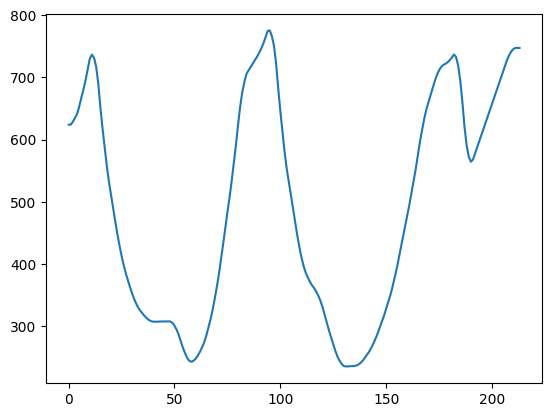

In [30]:
plt.plot(df_ball_positions['mid_y_rolling_mean'])

Calculating where exactly ball was hit (change in y)

In [31]:
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

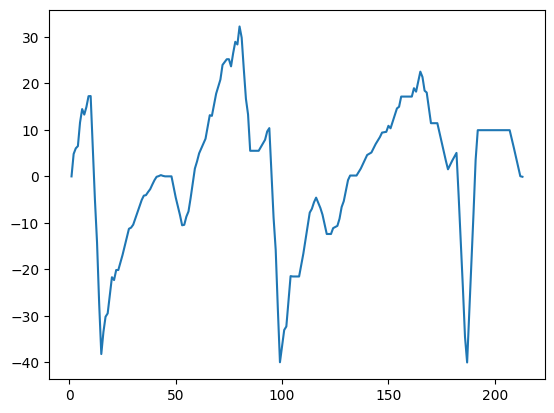

In [32]:
plt.plot(df_ball_positions['delta_y'])

In [33]:
df_ball_positions['ball_hit'] = 0

In [40]:
minimum_change_frames_for_hit = 25
for i in range(1,len(df_ball_positions)- int(minimum_change_frames_for_hit*1.2) ):
    negative_position_change = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[i+1] <0
    positive_position_change = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[i+1] >0

    if negative_position_change or positive_position_change:
        change_count = 0 
        for change_frame in range(i+1, i+int(minimum_change_frames_for_hit*1.2)+1):
            negative_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] >0 and df_ball_positions['delta_y'].iloc[change_frame] <0
            positive_position_change_following_frame = df_ball_positions['delta_y'].iloc[i] <0 and df_ball_positions['delta_y'].iloc[change_frame] >0

            if negative_position_change and negative_position_change_following_frame:
                change_count+=1
            elif positive_position_change and positive_position_change_following_frame:
                change_count+=1
    
        if change_count>minimum_change_frames_for_hit-1:
            df_ball_positions['ball_hit'].iloc[i] = 1

frame_nums_with_ball_hits = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()

C:\Users\DELL\AppData\Local\Temp\ipykernel_14036\3752280353.py:18: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df_ball_positions['ball_hit'].iloc[i] = 1
C:\Users\DELL\AppData\Local\Temp\ipykernel_14036\3752280353.py:18: SettingWithCopyWarn

In [35]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.697510,717.184814,796.941345,738.274170,727.729492,736.583514,6.239148,1
58,925.488611,241.277829,938.334485,254.123752,247.700790,242.809369,-1.481331,1
95,623.538727,748.427002,641.576721,767.019897,757.723450,775.551361,0.757812,1
131,716.175751,228.773872,729.044312,242.482544,235.628208,235.258604,-0.799422,1


In [39]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,777.697510,717.184814,796.941345,738.274170,727.729492,736.583514,6.239148,1
58,925.488611,241.277829,938.334485,254.123752,247.700790,242.809369,-1.481331,1
95,623.538727,748.427002,641.576721,767.019897,757.723450,775.551361,0.757812,1
131,716.175751,228.773872,729.044312,242.482544,235.628208,235.258604,-0.799422,1
